In [2]:
import os
import json
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

np.random.seed(42)

# Opt
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# 本地运行，不需要Colab
# notebook在 notebooks/ 文件夹，数据在 data/raw/
RAW_CSV_PATH = "../data/raw/Guns_incident_Data.csv"


In [4]:
                                        #3 → Load & Schema Cleanup
df = pd.read_csv(RAW_CSV_PATH, engine="pyarrow")

# Normalize
df.columns = df.columns.str.strip().str.replace(r"\s+", " ", regex=True)

# Map to concise schema
rename = {
    "S.No.": "id",
    "Year": "year",
    "Month": "month",
    "Date": "date_raw",
    "Reason": "reason",
    "Education": "education",
    "Sex": "sex",
    "Age": "age",
    "Race": "race",
    "Hispanic": "hispanic",
    "Place of in": "place",
    "Place of incident": "place",
    "Police involvement": "police_involvement",
}
df = df.rename(columns={k: v for k, v in rename.items() if k in df.columns})

# Keep core columns
keep_cols = [c for c in [
    "year","month","reason","education","sex","age","race","hispanic","place","police_involvement"
] if c in df.columns]
df = df[keep_cols].copy()

# Basic string sanitization
str_cols = [c for c in ["reason","education","sex","race","place"] if c in df.columns]
for c in str_cols:
    df[c] = (
        df[c]
        .astype("string")
        .str.strip()
        .str.replace(r"\s+", " ", regex=True)
        .str.lower()
    )

# Numeric coercions
for c in ["year","month","age","hispanic","police_involvement"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Clip binary flag to {0,1} if present
if "police_involvement" in df.columns:
    df["police_involvement"] = df["police_involvement"].clip(0, 1)

# Deduplicate
before = len(df)
df = df.drop_duplicates()
print(f"Loaded {before} rows → {len(df)} after dedup.")
df.head()


Loaded 100798 rows → 62267 after dedup.


,year,month,reason,education,sex,age,race,hispanic,place,police_involvement
0,2017,1,suicide,bachelors,male,35.0,asian/pacific islander,100,home,0
1,2017,1,suicide,some college,female,22.0,white,100,street,0
2,2017,1,suicide,bachelors,male,61.0,white,100,other specified,0
3,2017,2,suicide,bachelors,male,65.0,white,100,home,0
4,2017,2,suicide,high school,male,32.0,white,100,other specified,0


In [5]:
                             #4 → Missingness Snapshot
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame("missing_ratio").head(20))


,missing_ratio
education,0.022147
place,0.021022
age,0.000225
year,0.000000
month,0.000000
reason,0.000000
sex,0.000000
race,0.000000
hispanic,0.000000
police_involvement,0.000000


In [10]:
                                        #5 → Train/Val/Test Split
# Make dtypes sklearn-friendly
df = df.replace({pd.NA: np.nan})

num_like = [c for c in ["year","month","age","hispanic","police_involvement"] if c in df.columns]
cat_like = [c for c in ["reason","education","sex","race","place"] if c in df.columns]

for c in num_like:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("float64")
for c in cat_like:
    df[c] = df[c].astype("object")

# ===== 修改：reason是目标变量，需要分离 =====
# 去掉reason列中的null值
df_clean = df.dropna(subset=['reason']).copy()
print(f"Dropped {len(df) - len(df_clean)} rows with null target")

# 分离X和y
y = df_clean['reason'].copy()  # 目标变量
X = df_clean.drop(columns=['reason']).copy()  # 特征（去掉reason避免数据泄露）

print(f"\nTarget distribution:\n{y.value_counts()}")

# Split with stratify
from sklearn.model_selection import train_test_split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"\nShapes →  X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"         X_valid: {X_valid.shape} | y_valid: {y_valid.shape}")
print(f"         X_test: {X_test.shape} | y_test: {y_test.shape}")


Dropped 0 rows with null target

Target distribution:
reason
suicide         33893
homicide        25966
accidental       1603
undetermined      805
Name: count, dtype: int64

Shapes →  X_train: (43586, 9) | y_train: (43586,)
         X_valid: (9340, 9) | y_valid: (9340,)
         X_test: (9341, 9) | y_test: (9341,)


In [12]:
                                        #6 → ColumnTransformer & Pipeline → Auto-detect column types on TRAIN to avoid leakage

# Auto-detect on TRAIN
num_cols = [c for c in X_train.columns if pd.api.types.is_numeric_dtype(X_train[c])]
cat_cols = [c for c in X_train.columns if c not in num_cols]

numeric_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
])

# Compatibility for sklearn versions
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >= 1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)        # sklearn < 1.2

categorical_tf = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False,
)

preproc_pipe = Pipeline(steps=[("preprocess", preprocessor)])


In [14]:
                                        #7 →Fit on Train, Transform All Splits
# no lingering pd.NA objects
X_train = X_train.replace({pd.NA: np.nan})
X_valid = X_valid.replace({pd.NA: np.nan})
X_test  = X_test.replace({pd.NA: np.nan})

preproc_pipe.fit(X_train)

def transform_splits(pipe, X_tr, X_va, X_te):
    feat_names = pipe.named_steps["preprocess"].get_feature_names_out()
    Xtr = pd.DataFrame(pipe.transform(X_tr), columns=feat_names, index=X_tr.index)
    Xva = pd.DataFrame(pipe.transform(X_va), columns=feat_names, index=X_va.index)
    Xte = pd.DataFrame(pipe.transform(X_te), columns=feat_names, index=X_te.index)
    return Xtr, Xva, Xte, feat_names

Xtr_p, Xva_p, Xte_p, feature_names = transform_splits(preproc_pipe, X_train, X_valid, X_test)

print("Post-preprocess shapes:")
print("  X_train:", Xtr_p.shape)
print("  X_valid:", Xva_p.shape)
print("  X_test :", Xte_p.shape)


Post-preprocess shapes:
  X_train: (43586, 26)
  X_valid: (9340, 26)
  X_test : (9341, 26)


In [16]:
                                        #8 →Save processed splits + transformer
import os, json, joblib

ARTIFACT_DIR = "../data/processed"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

# 保存X（特征）
Xtr_p.to_parquet(os.path.join(ARTIFACT_DIR, "X_train.parquet"))
Xva_p.to_parquet(os.path.join(ARTIFACT_DIR, "X_valid.parquet"))
Xte_p.to_parquet(os.path.join(ARTIFACT_DIR, "X_test.parquet"))

# 保存y（目标变量）
y_train.to_csv(os.path.join(ARTIFACT_DIR, "y_train.csv"), index=False)
y_valid.to_csv(os.path.join(ARTIFACT_DIR, "y_valid.csv"), index=False)
y_test.to_csv(os.path.join(ARTIFACT_DIR, "y_test.csv"), index=False)

# 保存其他文件
pd.Series(feature_names).to_csv(os.path.join(ARTIFACT_DIR, "feature_names.csv"), index=False)
joblib.dump(preproc_pipe, os.path.join(ARTIFACT_DIR, "preprocessor.joblib"))

meta = {
    "numeric_columns_train": num_cols,
    "categorical_columns_train": cat_cols,
    "n_features_out": int(Xtr_p.shape[1]),
    "target_column": "reason",
    "target_classes": list(y_train.unique()),
}
with open(os.path.join(ARTIFACT_DIR, "data_dictionary.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Saved artifacts to:", ARTIFACT_DIR)


Saved artifacts to: ../data/processed


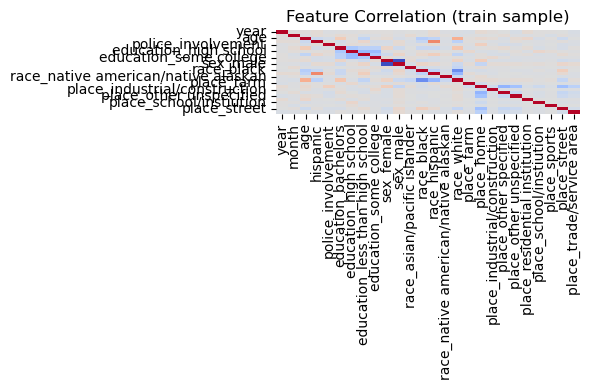

Feature count: 26
First 10 features: ['year' 'month' 'age' 'hispanic' 'police_involvement'
 'education_bachelors' 'education_high school'
 'education_less than high school' 'education_some college' 'sex_female']


In [18]:
                                        #9 → Quick sanity peek
import matplotlib.pyplot as plt
import seaborn as sns

corr_sample = Xtr_p.sample(min(1000, len(Xtr_p)), random_state=42)
corr = corr_sample.corr(numeric_only=True)

plt.figure(figsize=(6, 4))
sns.heatmap(corr.clip(-1,1), cmap="coolwarm", center=0, cbar=False)
plt.title("Feature Correlation (train sample)")
plt.tight_layout()
plt.show()

print("Feature count:", len(feature_names))
print("First 10 features:", feature_names[:10])
